<a href="https://colab.research.google.com/github/CD-AC/MLEngennier-Predictive_Maintenance_AI/blob/main/Predictive_Maintenance_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np

# Configuración inicial
np.random.seed(42)
days = pd.date_range(start='2023-01-01', end='2023-06-30', freq='D')
machines = [f'Machine_{i}' for i in range(1, 21)]

# Función para generar datos simulados para una máquina
def generate_machine_data(machine_id):
    data = {
        'Date': days,
        'Machine_ID': machine_id,
        'Operating_Hours': np.random.normal(20, 5, len(days)),  # Horas de operación
        'Vibration_Amplitude': np.random.normal(0.5, 0.1, len(days)),  # Amplitud de vibraciones
        'Temperature_Motor': np.random.normal(75, 5, len(days)),  # Temperatura del motor
        'Hydraulic_Pressure': np.random.normal(100, 10, len(days)),  # Presión hidráulica
        'Motor_Speed': np.random.normal(1500, 50, len(days)),  # Velocidad del motor
        'Current_Consumption': np.random.normal(15, 2, len(days)),  # Consumo de corriente
        'Bearing_Wear': np.random.normal(0.2, 0.05, len(days)),  # Desgaste de rodamientos
        'Errors': np.random.poisson(0.1, len(days)),  # Eventos de error
        'Products_Processed': np.random.poisson(100, len(days)),  # Productos procesados
        'Unplanned_Downtime': np.random.normal(0.5, 0.2, len(days))  # Tiempo de inactividad no planificada
    }
    return pd.DataFrame(data)

# Generar datos para todas las máquinas
df_list = [generate_machine_data(machine) for machine in machines]
dataset = pd.concat(df_list)

# Mostrar las primeras filas del dataset
print(dataset.head())

        Date Machine_ID  Operating_Hours  Vibration_Amplitude  \
0 2023-01-01  Machine_1        22.483571             0.414284   
1 2023-01-02  Machine_1        19.308678             0.392911   
2 2023-01-03  Machine_1        23.238443             0.548247   
3 2023-01-04  Machine_1        27.615149             0.477654   
4 2023-01-05  Machine_1        18.829233             0.571400   

   Temperature_Motor  Hydraulic_Pressure  Motor_Speed  Current_Consumption  \
0          74.456199          114.415686  1508.543272            15.092873   
1          77.008559           75.283555  1490.800833            12.280288   
2          78.450720           92.031047  1500.921697            16.492507   
3          72.993898          105.770721  1517.379085            16.290968   
4          76.120462           97.969546  1473.012016            19.326509   

   Bearing_Wear  Errors  Products_Processed  Unplanned_Downtime  
0      0.251514       0                 102            0.319218  
1      0

In [10]:
# Guardar el dataset en un archivo CSV
dataset.to_csv('mp_dataset.csv', index=False)


# Import Dependencies

In [ ]:
!pip install seaborn scikit-learn xgboost joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import joblib

# Configuración de visualización
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# EDA

In [ ]:
# Cargar y Explorar los Datos
data = pd.read_csv('/content/predictive_maintenance.csv')

# Mostrar información básica y descripción del dataset
print(data.info())
print(data.describe())

# Ver las primeras filas del dataset
data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          100000 non-null  float64
 1   sensor2          100000 non-null  float64
 2   sensor3          100000 non-null  float64
 3   sensor4          100000 non-null  float64
 4   sensor5          100000 non-null  float64
 5   temperature      100000 non-null  float64
 6   pressure         100000 non-null  float64
 7   humidity         100000 non-null  float64
 8   operating_hours  100000 non-null  int64  
 9   failure          100000 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 7.6 MB
None
             sensor1        sensor2        sensor3        sensor4  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       50.009669      60.014716      54.981900      51.998710   
std        10.009060      14.984090      11.998227      10.01594

,sensor1,sensor2,sensor3,sensor4,sensor5,temperature,pressure,humidity,operating_hours,failure
0,54.967142,75.458919,73.742089,38.001783,100.495962,64.684876,35.478707,37.222495,1495,0
1,48.617357,42.669678,53.869260,57.478228,55.926624,65.898740,29.669419,41.609828,1112,0
2,56.476885,68.631558,39.045573,50.792377,33.755394,73.416150,27.817968,41.085192,1808,0
3,65.230299,50.711423,38.336342,49.167362,65.210549,72.089496,28.917985,45.308876,946,0
4,47.658466,55.088958,50.888191,59.675692,57.107625,72.112291,34.319132,40.083061,1987,0


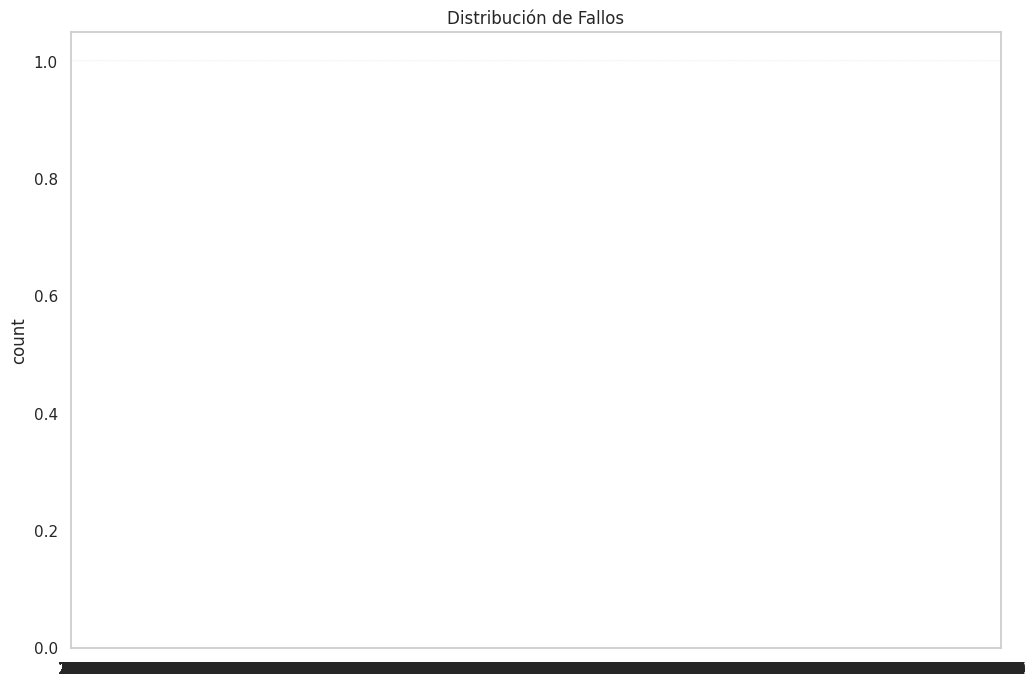

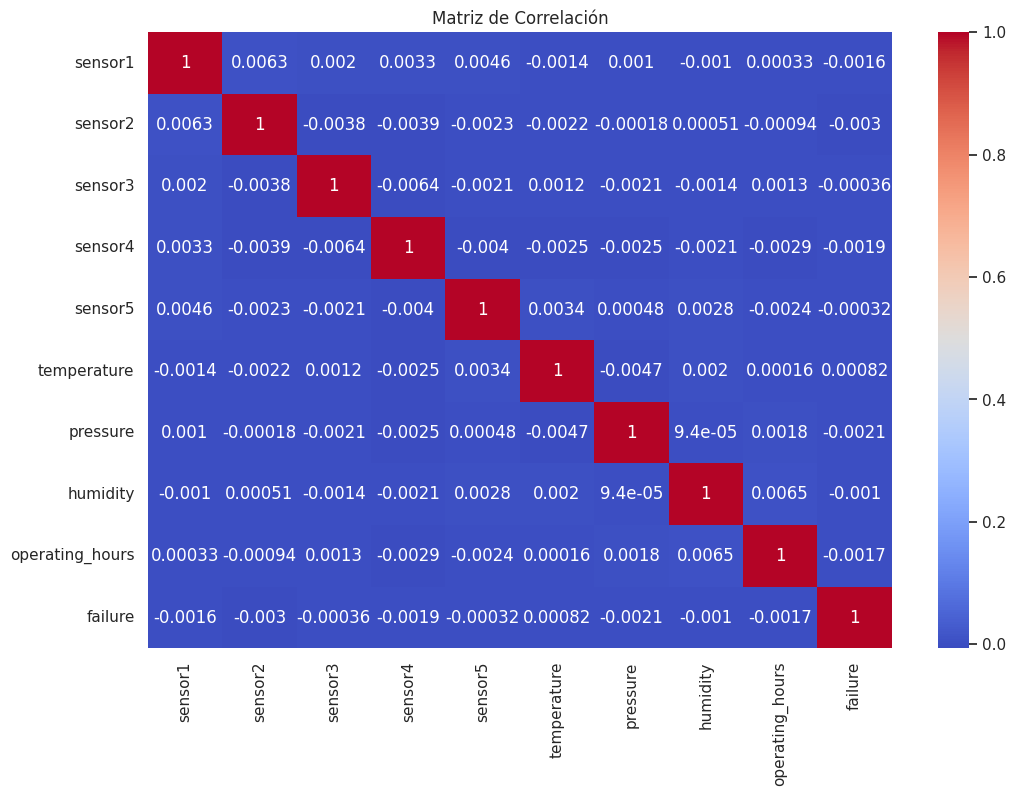

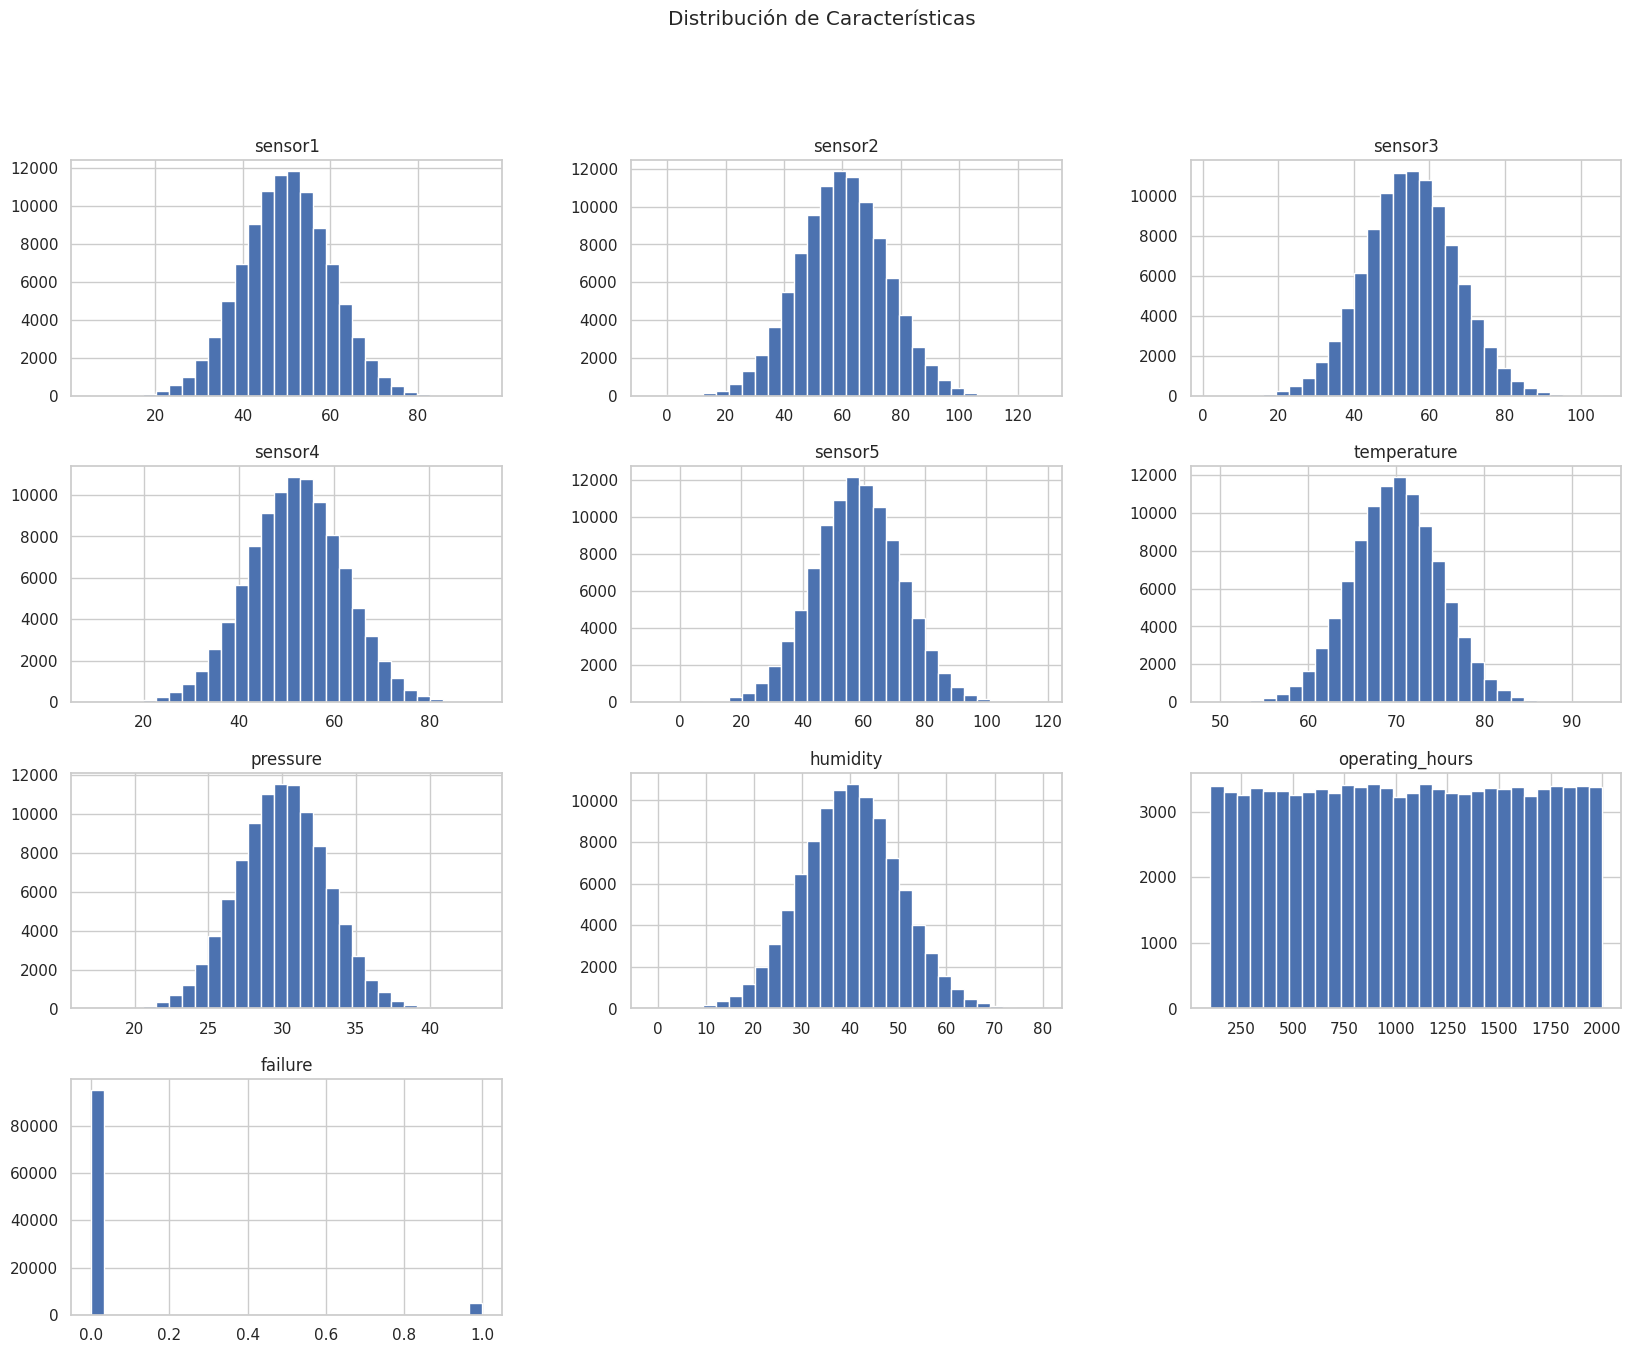

In [ ]:
# Ver distribución de la variable objetivo
sns.countplot(data['failure'])
plt.title('Distribución de Fallos')
plt.show()

# Visualización de las correlaciones
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Visualización de la distribución de cada característica
data.hist(bins=30, figsize=(20, 15))
plt.suptitle('Distribución de Características')
plt.show()


In [ ]:
# Preprocesamiento de Datos
# Manejo de valores nulos
data = data.fillna(method='ffill')  # o cualquier otra estrategia adecuada

# Creación de nuevas características (si es relevante)
data['sensor_diff'] = data['sensor1'] - data['sensor2']

# Separar las características y la variable objetivo
X = data.drop('failure', axis=1)
y = data['failure']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Entrenamiento del Modelo con Validación Cruzada y Ajuste de Hiperparámetros
# Definir el modelo
model = xgb.XGBClassifier()

# Definir la búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_

# Resultados de la búsqueda de hiperparámetros
print(grid_search.best_params_)
print(grid_search.best_score_)


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.9488857142857142


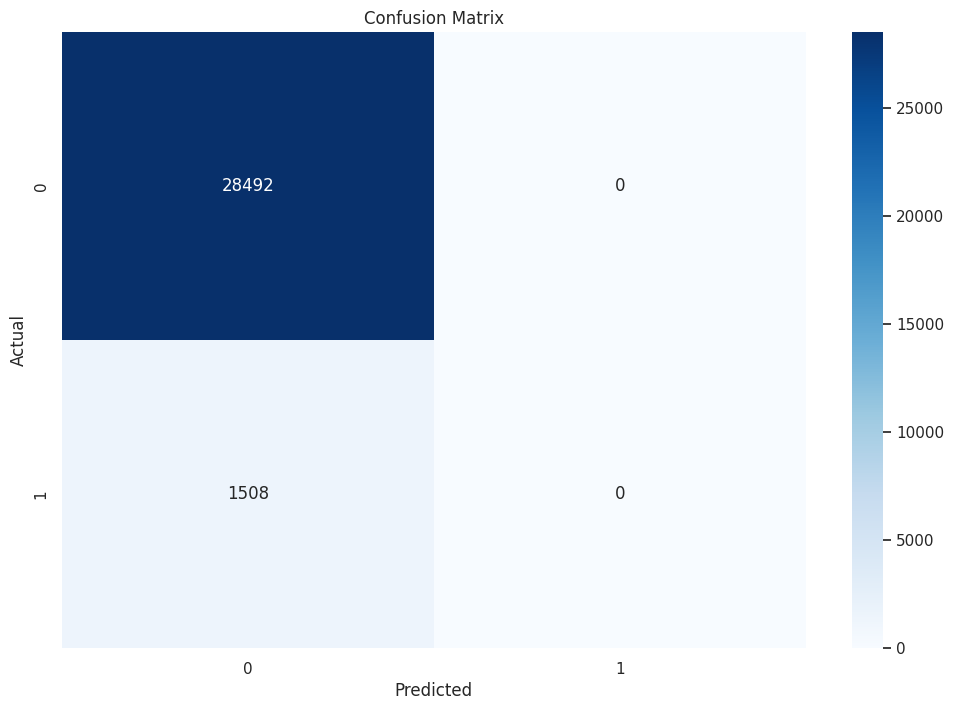

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28492
           1       0.00      0.00      0.00      1508

    accuracy                           0.95     30000
   macro avg       0.47      0.50      0.49     30000
weighted avg       0.90      0.95      0.93     30000



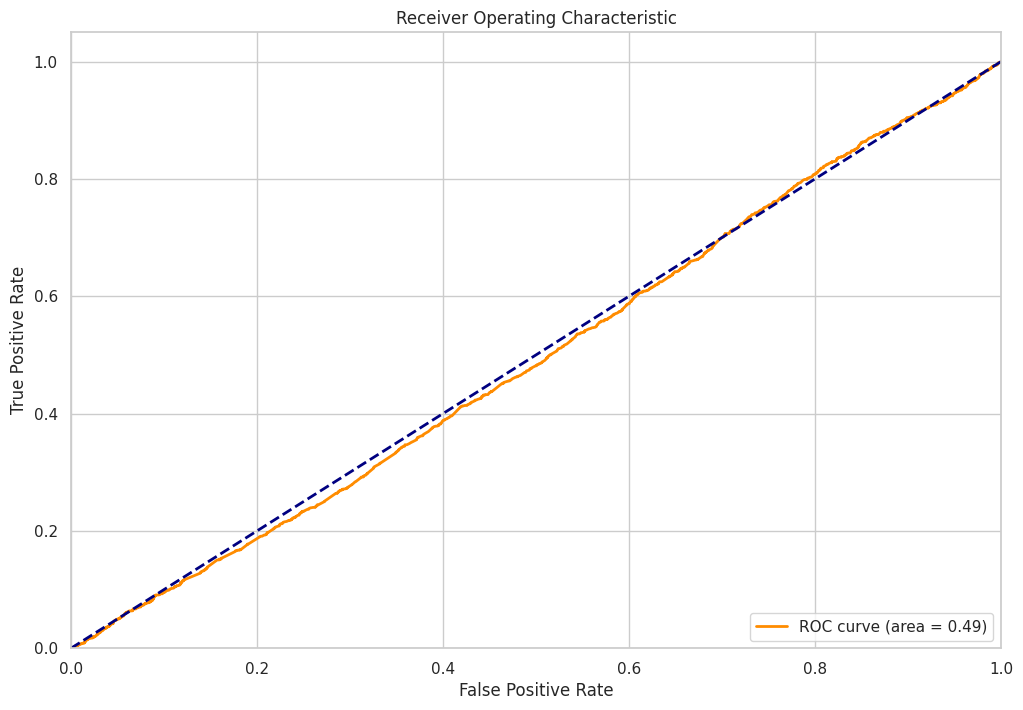

In [ ]:
# Evaluación del Modelo
# Realizar predicciones
y_pred = best_model.predict(X_test_scaled)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred))

# Curva ROC
y_prob = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Implementación en Producción
# Exportar el modelo
joblib.dump(best_model, 'predictive_maintenance_model.pkl')

# Ejemplo de carga del modelo en producción y predicción
def predict_failure(sensor_data):
    model = joblib.load('predictive_maintenance_model.pkl')
    scaler = joblib.load('scaler.pkl')
    sensor_data_scaled = scaler.transform([sensor_data])
    prediction = model.predict(sensor_data_scaled)
    return prediction

# Guardar el escalador también
joblib.dump(scaler, 'scaler.pkl')

# Uso en producción
sensor_data_example = [0.5, 0.7, 0.2, 0.4, 0.6]
print(predict_failure(sensor_data_example))
